In [ ]:
import PIL
from PIL import Image
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
#from data_loader import DataLoader
import sys
import os
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from matplotlib import image
G_losses = []
D_losses = []
accuracy=[]

In [ ]:
dir = '/content/drive/MyDrive/cats '

In [ ]:
name_image_list = os.listdir(dir+'/cats')
BUFFER_SIZE = len(name_image_list)
real_images = np.ndarray(shape=(len(name_image_list), 64, 64, 3), dtype='float32')
for i in range(len(name_image_list)):
    real_images[i] = image.imread(dir +'/cats/'+ name_image_list[i])

In [ ]:
class GAN():

    def __init__(self):
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        X_train = tf.data.Dataset.from_tensor_slices((real_images - 127.5) / 127.5).shuffle(BUFFER_SIZE).batch(128)
        # X_train = X_train.make_one_shot_iterator()
        # X_train = np.column_stack(list(X_train))
        # Rescale -1 to 1
        # X_train = X_train / 127.5 - 1.
        # X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            for data in X_train:

                # idx = np.random.randint(0, X_train.shape[0], batch_size)
                if data.shape[0] == batch_size:
                    imgs = data
                    noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                    # Generate a batch of new images
                    gen_imgs = self.generator.predict(noise)

                    # Train the discriminator
                    d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                    d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                    # ---------------------
                    #  Train Generator
                    # ---------------------

                    noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                    # Train the generator (to have the discriminator label samples as valid)
                    g_loss = self.combined.train_on_batch(noise, valid)

                    # Plot the progress
                    print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))

                    G_losses.append(d_loss[0])
                    D_losses.append(g_loss)
                    accuracy.append(100 * d_loss[1])
                    # If at save interval => save generated image samples
                    if epoch % sample_interval == 0:
                        self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


In [15]:
from tensorflow import keras

if __name__ == '__main__':
    if not os.path.exists("./images"):
        os.makedirs("./images")
    gan = GAN()
    gan.train(epochs=100, batch_size=128, sample_interval=10)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 12288)             0         
                                                                 
 dense_18 (Dense)            (None, 512)               6291968   
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 256)               65792     
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 256)              

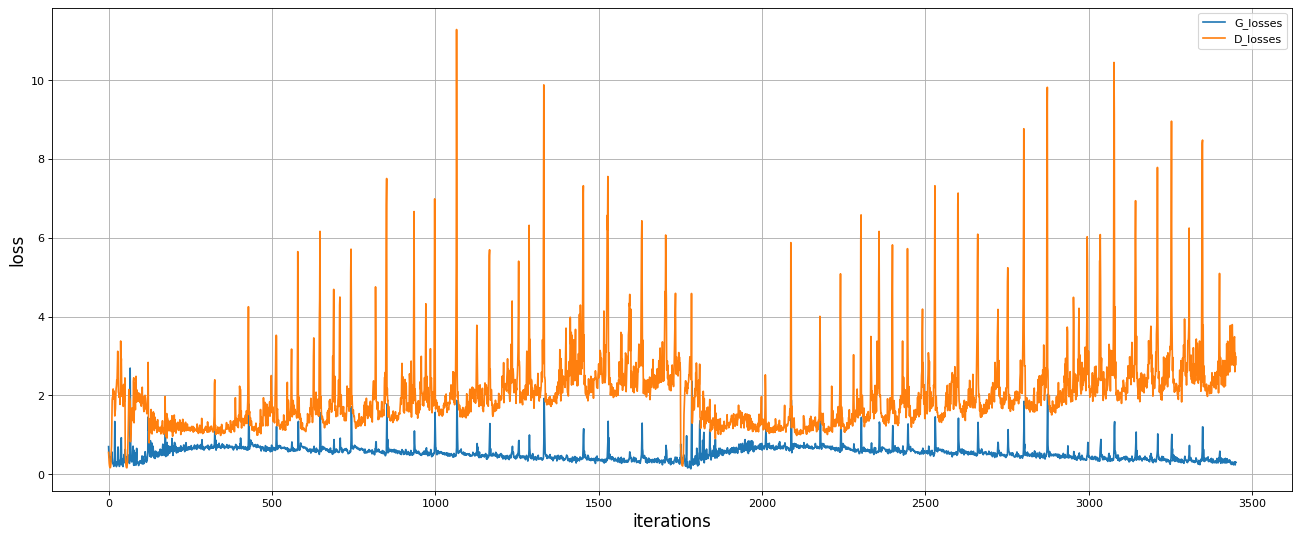

In [16]:
    x = [i for i in range(len(G_losses))]
    figure = plt.figure(figsize=(20, 8), dpi=80)
    plt.plot(x, G_losses, label='G_losses')
    plt.plot(x, D_losses, label='D_losses')
    plt.xlabel("iterations", fontsize=15)
    plt.ylabel("loss", fontsize=15)
    plt.legend()
    plt.grid()
    plt.show()

   


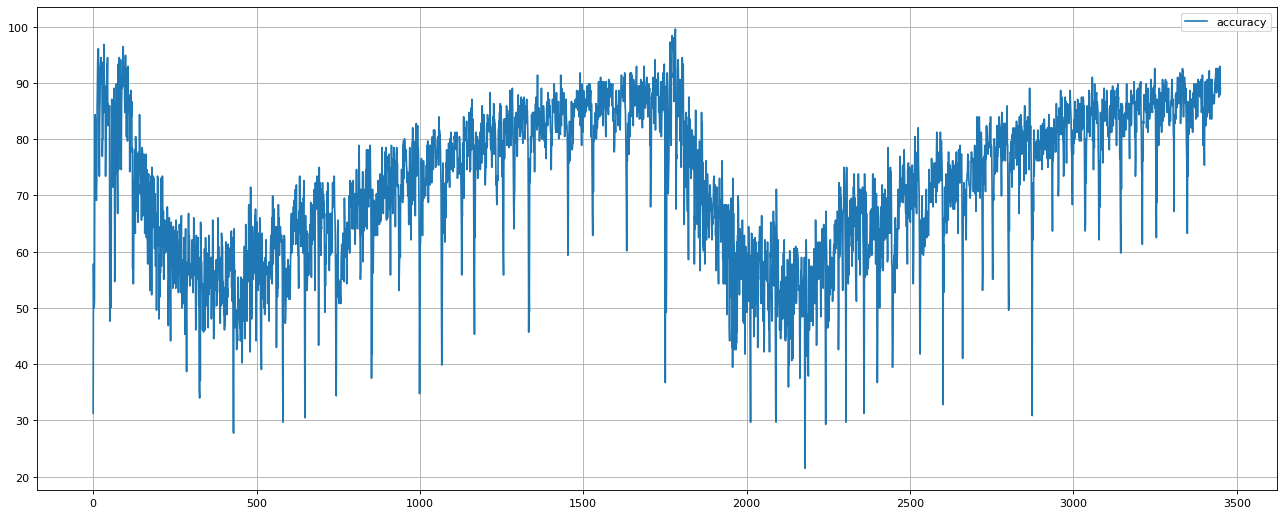

In [17]:
    x = [i for i in range(len(accuracy))]
    figure = plt.figure(figsize=(20, 8), dpi=80)
    plt.plot(x, accuracy, label='accuracy')
    plt.legend()
    plt.grid()
    plt.show()
